In [1]:
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import ast
from pathlib import Path
from collections import defaultdict

In [2]:
output_dir =  'data'
os.makedirs('data', exist_ok=True)

genre_mapping = {
    "hip-hop": "hip-hop",
    "hip hop": "hip-hop",
    "hiphop": "hip-hop",
    "rap": "hip-hop",
    "trap": "hip-hop",
    "r&b": "rnb",
    "metal": "metal",
    "r&b": "rnb",
    "rnb": "rnb",
    "rock": "rock",
    "pop": "pop",
    "rock n roll": "rock",
    "indie rock": "rock",
    "alt rock": "rock",
    "electronic": "edm",
    "edm": "edm",
    "dance": "edm",
    "techno": "edm",
    "metalcore": "metal",
    "death metal": "metal",
    "heavy metal": "metal",
    "country": "country",
    # Add more mappings here
}

def clean_text(text):
    allowed = r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,:;!?\'"\-\(\)\[\]\\/ $%#&]'
    return re.sub(allowed, '', text)

def standardize_genres(df: pl.DataFrame, genre_map: dict[str, str] = None) -> pl.DataFrame:
    genre_col = df.columns[0]
    # Normalize genre values safely
    df = df.with_columns([
        pl.col(genre_col).map_elements(normalize_genre).alias(genre_col)
    ])
    print(f"Unique genres before mapping: {df[genre_col].unique().to_list()}")
    if genre_map:
        # Apply genre mapping without changing unmapped genres
        df = df.with_columns([
            pl.col(genre_col).map_elements(lambda g: genre_map.get(g, g)).alias(genre_col)
        ])
    df = df.drop_nulls([genre_col])
    df = df.unique()
    return df

def normalize_genre(genre: str) -> str:
    try:
        genre = str(genre).lower().strip()
        genre = genre.replace("_", " ")
        return genre
    except Exception as e:
        print(f"Genre normalization failed for value: {genre} | Error: {e}")
        return "unknown"

def merge_all_csvs(csv_paths: list[str], genre_mapping: dict[str, str]) -> pl.DataFrame:
    dfs = []
    for path in csv_paths:
        df = pl.read_csv(path)
        print(f"File: {path}, Shape: {df.shape}, Columns: {df.columns}")
        try:
            df = standardize_genres(df, genre_mapping)
            dfs.append(df)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    merged = pl.concat(dfs, how="vertical")
    return merged.unique()

def extract_all_genres(folder_path: str) -> set[str]:
    """Scan every *.csv in folder_path and collect all unique genres."""
    genres: set[str] = set()
    for csv in Path(folder_path).glob("*.csv"):
        df = pl.read_csv(csv)
        genre_col = df.columns[0]         
        genres.update(df[genre_col].unique().to_list())
    return genres

Data from https://github.com/etarakci/music-genre-prediction/tree/master

In [3]:
df = pl.read_csv('source_data/genre_lyrics_data.csv') 
df

,genre_name,lyrics_cleaned
i64,str,str
0,"""acoustic""","""well you done done me and you …"
1,"""acoustic""","""head under water and they tell…"
2,"""acoustic""","""will you count me in ive been …"
3,"""acoustic""","""do you hear me im talking to y…"
4,"""acoustic""","""the strands in your eyes that …"
…,…,…
6728,"""world-music""","""every time i fall down on my f…"
6729,"""world-music""","""and let this be a sacrifice le…"
6730,"""world-music""","""as the sun begins to rise in t…"


In [4]:
df = pl.read_csv('source_data/genre_lyrics_data.csv') 
df_filtered = df.select([
    pl.col("genre_name")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("lyrics_cleaned")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "genre_lyrics_data.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Filtered CSV saved to: data/genre_lyrics_data.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""folk""","""come out virginia dont let me …"
"""heavy-metal""","""the devils heldhound scenting …"
"""dancehall""","""let me now gimme another chanc…"
"""blues""","""im sending a raven black bird …"
"""country""","""the bluest skies dont seem so …"
…,…
"""alternative""","""i fell down to earth from a hu…"
"""world-music""","""here i remind myself what you …"
"""opera""","""like the sound of silence call…"


Data from https://data.mendeley.com/datasets/3t9vbwxgr5/2

In [5]:
df = pl.read_csv('source_data/tcc_ceds_music.csv') 
df

,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
i64,str,str,i64,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
0,"""mukesh""","""mohabbat bhi jhoothi""",1950,"""pop""","""hold time feel break feel untr…",95,0.000598,0.063746,0.000598,0.000598,0.000598,0.048857,0.017104,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.000598,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.13711,"""sadness""",1.0
4,"""frankie laine""","""i believe""",1950,"""pop""","""believe drop rain fall grow be…",51,0.035537,0.096777,0.443435,0.001284,0.001284,0.027007,0.001284,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,0.001284,0.331745,0.64754,0.954819,0.000002,0.325021,0.26324,"""world/life""",1.0
6,"""johnnie ray""","""cry""",1950,"""pop""","""sweetheart send letter goodbye…",24,0.00277,0.00277,0.00277,0.00277,0.00277,0.00277,0.158564,0.250668,0.00277,0.323794,0.00277,0.00277,0.00277,0.00277,0.00277,0.225422,0.456298,0.585288,0.840361,0.0,0.351814,0.139112,"""music""",1.0
10,"""pérez prado""","""patricia""",1950,"""pop""","""kiss lips want stroll charm ma…",54,0.048249,0.001548,0.001548,0.001548,0.0215,0.001548,0.411536,0.001548,0.001548,0.001548,0.12925,0.001548,0.001548,0.081132,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.77535,0.743736,"""romantic""",1.0
12,"""giorgos papadopoulos""","""apopse eida oneiro""",1950,"""pop""","""till darling till matter know …",48,0.00135,0.00135,0.417772,0.00135,0.00135,0.00135,0.46343,0.00135,0.00135,0.00135,0.00135,0.00135,0.029755,0.00135,0.0688,0.00135,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,"""romantic""",1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
82447,"""mack 10""","""10 million ways""",2019,"""hip hop""","""cause fuck leave scar tick toc…",78,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.00135,0.391651,0.00135,0.435089,0.00135,0.00135,0.00135,0.065664,0.00135,0.889527,0.759711,0.062549,0.0,0.751649,0.695686,"""obscene""",0.014286
82448,"""m.o.p.""","""ante up (robbin hoodz theory)""",2019,"""hip hop""","""minks things chain ring bracle…",67,0.001284,0.001284,0.035338,0.001284,0.001284,0.001284,0.066324,0.203889,0.31891,0.058152,0.134955,0.001284,0.001284,0.040811,0.001284,0.001284,0.662082,0.78958,0.004607,0.000002,0.922712,0.797791,"""obscene""",0.014286
82449,"""nine""","""whutcha want?""",2019,"""hip hop""","""get ban get ban stick crack re…",77,0.001504,0.154302,0.168988,0.001504,0.039755,0.001504,0.035401,0.001504,0.356685,0.001504,0.068684,0.001504,0.001504,0.001504,0.001504,0.001504,0.663165,0.72697,0.104417,0.000001,0.838211,0.767761,"""obscene""",0.014286


In [6]:
df = pl.read_csv('source_data/tcc_ceds_music.csv') 
df_filtered = df.select([
    pl.col("genre")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("lyrics")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "tcc_ceds_music.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_filtered

Filtered CSV saved to: data/tcc_ceds_music.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""pop""","""hold time feel break feel untr…"
"""pop""","""believe drop rain fall grow be…"
"""pop""","""sweetheart send letter goodbye…"
"""pop""","""kiss lips want stroll charm ma…"
"""pop""","""till darling till matter know …"
…,…
"""hip-hop""","""cause fuck leave scar tick toc…"
"""hip-hop""","""minks things chain ring bracle…"
"""hip-hop""","""get ban get ban stick crack re…"


Data from https://huggingface.co/datasets/Veucci/lyric-to-3genre

In [7]:
df = pl.read_csv('source_data/data_3genre.csv') 
df

str
"""0|I walked through the door wi…"
"""0|Vintage tee brand new phone …"
"""0|I can see you standing honey…"
"""0|We could leave the Christmas…"
"""0|Im doing good Im on some new…"
…
"""2|Oh yeah oh yeah Oh yeah Ive …"
"""2|Yeah oh oh Yeah Why you make…"
"""2|Go figure You were the trigg…"
"""2|Yeah Yeah Uh Back up on my b…"


In [8]:
genre_map = {
    "0": "pop",
    "1": "rock",
    "2": "hip-hop"
}
rows = []
with open('source_data/data_3genre.csv', 'r', encoding='utf-8') as f:
    for line in f:
        if '|' in line:
            genre_code, lyrics = line.strip().split('|', 1)
            genre = genre_map.get(genre_code.strip(), "unknown").lower()
            lyrics = clean_text(lyrics.strip())
            rows.append((genre, lyrics))

df = pl.DataFrame(rows, schema=["genre", "lyrics"])
output_path = os.path.join(output_dir, "data_3genre.csv")
df.write_csv(output_path)
print(f"CSV saved to: {output_path}")
df.head()

CSV saved to: data/data_3genre.csv


/opt/miniconda3/envs/genre-lyrics/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


genre,lyrics
str,str
"""pop""","""I walked through the door with…"
"""pop""","""I walked through the door with…"
"""pop""","""Vintage tee brand new phone Hi…"
"""pop""","""I can see you standing honey W…"
"""pop""","""We could leave the Christmas l…"


Data from https://github.com/josch14/song-genre-classification-with-lyrics/blob/main/data/processed-data.csv

In [10]:
df = pl.read_csv('source_data/processed-data.csv') 
df

Lyric,Artist,Genres
str,str,str
"""Oh lord I'd like to know where…","""Olodum""","""Axé"""
"""Skin head Dead head Everybody …","""Olodum""","""Axé"""
"""And do And do The moment I sa…","""Carlinhos Brown""","""Axé"""
"""ALONE IN MY TIME / I FEEL MY B…","""Carlinhos Brown""","""Axé"""
"""I wanna tell you Wonderful thi…","""Carlinhos Brown""","""Axé"""
…,…,…
"""INTERNATIONAL THIEF THIEF (x3)…","""Fela Kuti""","""World Music"""
"""If you call woman African woma…","""Fela Kuti""","""World Music"""
"""Mr. follow follow Follow, fol…","""Fela Kuti""","""World Music"""


In [11]:
df = pl.read_csv('source_data/processed-data.csv') 
df_filtered = df.select([
    pl.col("Genres")
    .map_elements(normalize_genre) 
    .alias("genre"),
    
    pl.col("Lyric")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "processed-data.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Filtered CSV saved to: data/processed-data.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""trilha-sonora""","""(Narrator speaks) Once upon a …"
"""pop""","""Angels we have heard on high S…"
"""country""","""Think I'll grab a bottle of Pa…"
"""heavy-metal""","""They say that you've come to e…"
"""trip-hop""","""Three months in here Can't cat…"
…,…
"""rock""","""written by Warren Zevon 1980 Z…"
"""pós-punk""","""all your promises don't taste …"
"""indie""","""My friend Sits at the drum His…"


Data from https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification (train + test)

In [12]:
df = pl.read_csv('source_data/multilingual_train.csv') 
df

Artist,Song,Genre,Language,Lyrics
str,str,str,str,str
"""12 stones""","""world so cold""","""Rock""","""en""","""It starts with pain, followed …"
"""12 stones""","""broken""","""Rock""","""en""","""Freedom! Alone again again alo…"
"""12 stones""","""3 leaf loser""","""Rock""","""en""","""Biting the hand that feeds you…"
"""12 stones""","""anthem for the underdog""","""Rock""","""en""","""You say you know just who I am…"
"""12 stones""","""adrenaline""","""Rock""","""en""","""My heart is beating faster can…"
…,…,…,…,…
"""bobby womack""","""i wish he didn t trust me so m…","""R&B""","""en""","""I'm the best friend he's got I…"
"""bad boys blue""","""i totally miss you""","""Pop""","""en""","""Bad Boys Blue ""I Totally Miss …"
"""celine dion""","""sorry for love""","""Pop""","""en""","""Forgive me for the things That…"


In [13]:
df = pl.read_csv('source_data/multilingual_train.csv') 
df_filtered = (
    df
    .filter(pl.col("Language").is_in(["en"]))
    .select([
        pl.col("Genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("Lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "multilingual_train.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Filtered CSV saved to: data/multilingual_train.csv


genre,lyrics
str,str
"""rock""","""How did I ever get so lucky To…"
"""rock""","""i probably knew all along that…"
"""rock""","""My friend, is it still ringing…"
"""indie""","""Come pick me up in the morning…"
"""rock""","""Oh break it, burn it, drag it …"
…,…
"""pop""","""(Michael's speak) Have you see…"
"""rock""","""A-well-a ev'rybody's heard abo…"
"""rock""","""We are two and two of us are o…"


In [18]:
df = pl.read_csv('source_data/multilingual_test.csv') 
df

Song,Song year,Artist,Genre,Lyrics,Track_id
str,i64,str,str,str,i64
"""craftsmanship""",2005,"""buck-65""","""Hip-Hop""","""Most folks spend their days da…",8294
"""come-on-out""",2012,"""the-elwins""","""Indie""","""Take your cold hands and put t…",21621
"""riot""",2013,"""bullet-for-my-valentine""","""Metal""","""Are you ready it's time for wa…",3301
"""that-s-what-girls-do""",2007,"""dream-street""","""Pop""","""You ask me why I change the co…",2773
"""believe-in-a-dollar""",2012,"""cassidy""","""Hip-Hop""","""Do you believe in magic in a y…",16797
…,…,…,…,…,…
"""too-little-too-late""",2006,"""amanda-marshall""","""Rock""","""Tuesday night - 7:30 I hear a …",23453
"""berserker""",2007,"""aurora-borealis""","""Metal""","""Elite forces cloaked in fur un…",2724
"""natural-born-killaz""",2010,"""dr-dre""","""Hip-Hop""","""[Dr. Dre] Journey with me Into…",24147


In [14]:
df = pl.read_csv('source_data/multilingual_test.csv') 
df_filtered = (
    df
    .select([
        pl.col("Genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("Lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "multilingual_test.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Filtered CSV saved to: data/multilingual_test.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""metal""","""(Fiend talking) My Lord, I'm i…"
"""rock""","""I hear you America snoring I h…"
"""country""","""Well I knew this town was head…"
"""edm""","""I feel so much sensation You'v…"
"""rock""","""Always alone Never with a herd…"
…,…
"""jazz""","""The lady with the big umbrella…"
"""jazz""","""Well I'm sitting on the front …"
"""folk""","""Rinne m smaointeamh in m'intin…"


Popular songs from Spotify

In [15]:
df = pl.read_csv('source_data/most_popular_spotify_songs.csv') 
df

genre,lyrics
str,str
"""Pop""","""['bring', 'me', 'higher', 'lov…"
"""Pop""","""['yeah,', 'yeah', 'oh,', 'ah',…"
"""Pop""","""['one', 'more', 'drink,', 'got…"
"""Pop""","""['(sixteen)', '(sixteen)', 'do…"
"""Pop""","""[""i'm"", 'losing', 'my', 'self'…"
…,…
"""Edm""","""['vamo', 'assim', 'segura', 'a…"
"""Edm""","""['pensa', 'numa', 'histria...'…"
"""Edm""","""[""i'm"", 'so', 'into', 'you', '…"


In [16]:
df = pl.read_csv('source_data/most_popular_spotify_songs.csv') 
def parse_and_join_lyrics(lyrics_str):
    try:
        lyrics_list = ast.literal_eval(lyrics_str)
        return " ".join(lyrics_list)
    except Exception:
        return clean_text(lyrics).replace('"', '')

df_filtered = (
    df
    .select([
        pl.col("genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "most_popular_spotify_songs.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

Filtered CSV saved to: data/most_popular_spotify_songs.csv


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

genre,lyrics
str,str
"""latin""","""['s,', 's', 'ya', 'dime', 'si'…"
"""pop""","""['she', 'got', 'the', 'mmm,', …"
"""latin""","""['tu', 'novio', 'es', 'un', 'b…"
"""latin""","""['montana', 'posty', '(hahaha)…"
"""pop""","""['i', 'had', 'a', 'dream', 'i'…"
…,…
"""pop""","""['du-du-du-du-du-du-du', 'du-d…"
"""pop""","""[i'm, 'sorry', 'but', don't, '…"
"""hip-hop""","""['desde', 'que', estabamo', 'e…"


Spotify songs

In [24]:
df = pl.read_csv("source_data/spotify_480k.csv", has_header=True)
df = df.select(["genre", "lyrics"])

df_filtered = (
    df
    .select([
        pl.col("genre")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "spotify_480k.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Filtered CSV saved to: data/spotify_480k.csv


genre,lyrics
str,str
"""hip-hop""","""Many times I've walked the lin…"
"""indie,shoegaze,dream pop""","""[Verse 1] Days go by, no reply…"
"""hip-hop""","""[Intro/Chorus] Be my Mia Walla…"
"""pop,electropop,trap""","""[Verse 1] Hey I know what I ca…"
"""hip-hop""","""Hearts of glass break wherever…"
…,…
"""pop,folk,country""","""Gee, Ma, I wanna go, but they …"
"""alternative rock,rock,indie ro…","""[Verse 1] Mama don't want me f…"
"""hip-hop""","""[Verse 1] Fled on foot to some…"


Data from https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres

In [20]:
artists_df = pl.read_csv(
    "source_data/artists-data.csv",
    encoding="utf8-lossy", 
    quote_char='"',        
    ignore_errors=True    
)
artists_df.head()

Artist,Genres,Songs,Popularity,Link
str,str,i64,f64,str
"""Ivete Sangalo""","""Pop; Axé; Romântico""",313,4.4,"""/ivete-sangalo/"""
"""Chiclete com Banana""","""Axé""",268,3.8,"""/chiclete-com-banana/"""
"""Banda Eva""","""Axé; Romântico; Reggae""",215,2.3,"""/banda-eva/"""
"""É O Tchan""","""Axé""",129,1.6,"""/e-o-tchan/"""
"""Claudia Leitte""","""Pop; Axé; Romântico""",167,1.5,"""/claudia-leitte/"""


In [21]:
lyrics_df = pl.read_csv(
    "source_data/lyrics-data.csv",
    encoding="utf8-lossy",
    quote_char='"',
    ignore_errors=True
)
lyrics_df.head()

ALink,SName,SLink,Lyric,language
str,str,str,str,str
"""/ivete-sangalo/""","""Arerê""","""/ivete-sangalo/arere.html""","""Tudo o que eu quero nessa vida…","""pt"""
"""/ivete-sangalo/""","""Se Eu Não Te Amasse Tanto Assi…","""/ivete-sangalo/se-eu-nao-te-am…","""Meu coração Sem direção Voando…","""pt"""
"""/ivete-sangalo/""","""Céu da Boca""","""/ivete-sangalo/chupa-toda.html""","""É de babaixá! É de balacubaca!…","""pt"""
"""/ivete-sangalo/""","""Quando A Chuva Passar""","""/ivete-sangalo/quando-a-chuva-…","""Quando a chuva passar Pra quê…","""pt"""
"""/ivete-sangalo/""","""Sorte Grande""","""/ivete-sangalo/sorte-grande.ht…","""A minha sorte grande foi você …","""pt"""


In [22]:
artists_df = pl.read_csv("source_data/artists-data.csv", encoding="utf8-lossy", quote_char='"', ignore_errors=True)
lyrics_df = pl.read_csv("source_data/lyrics-data.csv", encoding="utf8-lossy", quote_char='"', ignore_errors=True)
merged_df = lyrics_df.join(artists_df, left_on="ALink", right_on="Link", how="inner")
final_df = merged_df.select([
    pl.col("Genres")
    .map_elements(normalize_genre) 
    .alias("genre"),
        
    pl.col("Lyric")
    .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
    .alias("lyrics")
])
df_standardized = standardize_genres(final_df, genre_mapping)
output_path = os.path.join(output_dir, "artists_lyrics.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_standardized

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_3745/4165869269.py:36: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([
/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_3745/4165869269.py:40: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([


Filtered CSV saved to: data/artists_lyrics.csv


genre,lyrics
str,str
"""regional;-sertanejo""","""Compadre velho, boleia a perna…"
"""r&b;-chillout;-pop""","""I'm looking back Now thinking,…"
"""sertanejo;-romântico;-forró""","""Deus, ela foi capaz de pedir p…"
"""r&b;-black-music;-funk""","""B-side of Gett Off Boy, we get…"
"""pop;-dance;-hip-hop""","""And they all fell From the sky…"
…,…
"""gospel/religioso""","""Jesus eu te agradeo neste mome…"
"""sertanejo""","""Voc meu brao direito o amor …"
"""sertanejo;-romântico""","""Olha, o nosso amor valeu Quand…"


### [Genius Song Lyrics](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information) - the biggest dataset (multilingual)

In [27]:
df = pl.read_csv('source_data/song_lyrics.csv') 
df

title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
str,str,str,i64,i64,str,str,i64,str,str,str
"""Killa Cam""","""rap""","""Cam'ron""",2004,173166,"""{""Cam\\'ron"",""Opera Steve""}""","""[Chorus: Opera Steve & Cam'ron…",1,"""en""","""en""","""en"""
"""Can I Live""","""rap""","""JAY-Z""",1996,468624,"""{}""","""[Produced by Irv Gotti] [Intr…",3,"""en""","""en""","""en"""
"""Forgive Me Father""","""rap""","""Fabolous""",2003,4743,"""{}""","""Maybe cause I'm eatin And thes…",4,"""en""","""en""","""en"""
"""Down and Out""","""rap""","""Cam'ron""",2004,144404,"""{""Cam\\'ron"",""Kanye West"",""Syl…","""[Produced by Kanye West and Br…",5,"""en""","""en""","""en"""
"""Fly In""","""rap""","""Lil Wayne""",2005,78271,"""{}""","""[Intro] So they ask me ""Young …",6,"""en""","""en""","""en"""
…,…,…,…,…,…,…,…,…,…,…
"""Ocean""","""pop""","""Effemar""",2022,3,"""{}""","""[Verse 1] Dance for me now Kee…",7882842,"""en""","""en""","""en"""
"""64 Bars""","""rap""","""Rapido""",2022,4,"""{}""","""[Intro] Ja, ja [Part 1] R-A…",7882843,"""de""","""de""","""de"""
"""Raise Our Hands""","""pop""","""Culture Code, Pag & Mylo""",2016,3,"""{Elex,""Culture Code / Pag & My…","""[Verse 1] Here our purpose fee…",7882845,"""en""","""en""","""en"""


In [28]:
df = pl.read_csv('source_data/song_lyrics.csv') 
df_filtered = (
    df
    .filter(pl.col("language").is_in(["en", "ru"]))
    .select([
        pl.col("tag")
        .map_elements(normalize_genre) 
        .alias("genre"),
        
        pl.col("lyrics")
        .map_elements(lambda x: clean_text(x).replace('"', '') if isinstance(x, str) else '')
        .alias("lyrics")
    ])
)
df_standardized = standardize_genres(df_filtered, genre_mapping)
output_path = os.path.join(output_dir, "song_lyrics.csv")
df_standardized.write_csv(output_path)
print(f"Filtered CSV saved to: {output_path}")
df_filtered

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Filtered CSV saved to: data/song_lyrics.csv


genre,lyrics
str,str
"""rap""","""[Chorus: Opera Steve & Cam'ron…"
"""rap""","""[Produced by Irv Gotti] [Intr…"
"""rap""","""Maybe cause I'm eatin And thes…"
"""rap""","""[Produced by Kanye West and Br…"
"""rap""","""[Intro] So they ask me Young b…"
…,…
"""pop""","""Everything is alright now Oh y…"
"""pop""","""[Verse 1] Half truth and half …"
"""pop""","""[Verse 1] Dance for me now Kee…"


In [3]:
original_genres = extract_all_genres(output_dir)
print(f"Original genres found ({len(original_genres)}):", original_genres)
csv_files = list(Path(output_dir).glob("*.csv"))
merged_df = merge_all_csvs([str(p) for p in csv_files], genre_mapping)
merged_df.write_csv("merged_genre_lyrics.csv")
merged_df.write_parquet("all_data.parquet")
merged_genres = set(merged_df.select(merged_df.columns[0]).unique().to_series())
print(f"Merged genres found ({len(merged_genres)}):", merged_genres)
print("Merged and cleaned dataset saved.")

Original genres found (4848): {'pop rock,electronic,pop', 'reggaeton;-electronica;-dance', 'pop,rap,jazz', 'electronic,indie rock,alternative rock', 'rock,pop rock,garage rock', 'screamo,pop punk,post-hardcore', 'indie pop,indie rock,indie', 'forró;-dance;-tecnopop', 'samba-enredo;-emocore;-black-music', 'j-pop/j-rock;-rock;-gótico', 'r&b;-hip-hop', 'rock;-hardcore;-rap', 'folk,alternative rock,rock', 'rock-alternativo;-punk-rock;-rock', 'punk,post-punk', 'soul,country,blues', 'garage rock,punk rock,rock', 'metal,melodic death metal,thrash metal', 'shoegaze,indie rock,dream pop', 'rock,alternative rock,nu metal', 'romântico;-pop;-forró', 'electronic,pop,disco', 'punk-rock;-hardcore', 'experimental,electronic,rock', 'post-hardcore,post-punk', 'electronic,pop,chillout', 'post-hardcore,alternative rock,indie rock', 'samba;-romântico;-pagode', 'metal,metalcore,death metal', 'soul-music;-mpb;-funk', 'funk,jazz', 'death metal,melodic death metal,metal', 'trilha-sonora;-rock;-k-pop/k-rock', '

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Unique genres before mapping: ['rock', 'country', 'hip-hop', 'pop', 'rb', 'misc']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/spotify_480k.csv, Shape: (481755, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['metal,post-hardcore', 'rock,pop rock,hard rock', 'rock,pop,pop rock', 'trap,cloud rap,emo rap', 'pop punk,alternative rock,punk rock', 'country,electropop,pop rock', 'disco,soul,alternative', 'progressive rock,pop,soundtrack', 'electronic,new wave', 'grime,dubstep,drum and bass', 'emo,lo-fi,emo rap', 'pop,rock,latin', 'new wave,indie pop,cloud rap', 'metalcore,nu metal,deathcore', 'lo-fi,psychedelic rock', 'rock,electronic,new wave', 'drum and bass,hip hop,gospel', 'alternative,industrial,synthpop', 'punk rock', 'rap,hip-hop,hip hop', 'alternative rock,indie rock,emo', 'gospel,soul', 'pop punk,punk,punk rock', 'punk rock,punk,pop punk', 'punk rock,pop punk,punk', 'electronic,synthpop,hip hop', 'alternative rock,grunge,psychedelic rock', 'punk rock,grunge', 'rock,nu metal', 'rock,hip-hop,punk rock', 'rap,hip hop,electropop', 'punk,punk rock,garage rock', 'pop punk,indie rock,emo

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/genre_lyrics_data.csv, Shape: (6455, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['anime', 'hard-rock', 'garage', 'goth', 'trance', 'jazz', 'punk-rock', 'breakbeat', 'piano', 'emo', 'j-rock', 'comedy', 'dubstep', 'gospel', 'afrobeat', 'alt-rock', 'drum-and-bass', 'latin', 'synth-pop', 'pop', 'show-tunes', 'new-age', 'folk', 'guitar', 'progressive-house', 'blues', 'groove', 'j-pop', 'hip-hop', 'industrial', 'black-metal', 'ska', 'ambient', 'metal', 'acoustic', 'mandopop', 'bluegrass', 'rock', 'world-music', 'german', 'alternative', 'heavy-metal', 'minimal-techno', 'j-idol', 'rockabilly', 'reggae', 'soul', 'disco', 'r-n-b', 'grindcore', 'indian', 'honky-tonk', 'swedish', 'dub', 'mpb', 'punk', 'death-metal', 'country', 'grunge', 'club', 'k-pop', 'indie', 'funk', 'j-dance', 'psych-rock', 'reggaeton', 'opera', 'salsa', 'malay', 'disney', 'power-pop', 'indie-pop', 'deep-house', 'british', 'singer-songwriter', 'french', 'electro', 'edm', 'dancehall', 'house', 'ch

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/artists_lyrics.csv, Shape: (374461, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['axé;-romântico;-dance', 'classic-rock;-rock;-pop/rock', 'power-pop;-indie', 'gospel/religioso;-pop;-romântico', 'pagode;-romântico;-trilha-sonora', 'pop;-jazz;-folk', 'forró;-dance;-tecnopop', 'heavy-metal;-gospel/religioso;-axé', 'gospel/religioso;-rock;-pop/rock', 'romântico;-jazz;-blues', 'romântico;-gospel/religioso;-pop', 'heavy-metal;-rock;-clássico', 'dance;-pop;-r&b', 'rock;-hardcore;-heavy-metal', 'mpb;-romântico;-folk', 'pop;-funk-carioca;-romântico', 'trilha-sonora;-axé', 'rock-alternativo;-grunge', 'pop/rock;-indie;-folk', 'rockabilly;-romântico;-rock', 'forró;-axé;-dance', 'indie;-rock', 'romântico;-pagode;-samba', 'trilha-sonora;-country', 'reggaeton;-reggae', 'infantil;-pop', 'indie;-emocore;-rock', 'blues;-jazz;-house', 'metal;-heavy-metal;-rock', 'house;-electronica;-dance', 'hip-hop;-rap;-electronica', 'pop;-mpb;-samba', 'pop/rock;-rock;-mpb', 'trip-hop;-ele

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/multilingual_test.csv, Shape: (7935, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['indie', 'pop', 'rnb', 'country', 'jazz', 'rock', 'metal', 'hip-hop', 'folk', 'edm']
File: data/data_3genre.csv, Shape: (3014, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['hip-hop', 'pop', 'rock']
File: data/processed-data.csv, Shape: (42091, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['samba', 'power-pop', 'industrial', 'fado', 'funk', 'house', 'axé', 'jazz', 'bossa-nova', 'trip-hop', 'reggae', 'punk-rock', 'trance', 'forró', 'blues', 'sertanejo', 'psicodelia', 'folk', 'country', 'rock-alternativo', 'rock', 'soul-music', 'j-pop/j-rock', 'pop/rock', 'soft-rock', 'indie', 'heavy-metal', 'reggaeton', 'grunge', 'new-wave', 'romântico', 'gospel/religioso', 'gótico', 'world-music', 'pop', 'infantil', 'trilha-sonora', 'clássico', 'edm', 'rnb', 'new-age', 'funk-carioca', 'disco', 'piano-rock', 'electronica', 'tecnopop', 'instrumental', 'ska', 

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/multilingual_train.csv, Shape: (220631, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['jazz', 'rnb', 'rock', 'country', 'indie', 'edm', 'pop', 'metal', 'folk', 'hip-hop']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

File: data/genius_ru_songs_filt.csv, Shape: (164541, 2), Columns: ['genre', 'lyrics']
Error processing data/genius_ru_songs_filt.csv: unable to add a column of length 2 to a DataFrame of height 1253
File: data/most_popular_spotify_songs.csv, Shape: (899, 2), Columns: ['genre', 'lyrics']
Unique genres before mapping: ['hip-hop', 'rnb', 'pop', 'edm', 'rock', 'latin']


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Merged genres found (4846): {'reggaeton;-electronica;-dance', 'pop rock,electronic,pop', 'pop,rap,jazz', 'electronic,indie rock,alternative rock', 'rock,pop rock,garage rock', 'screamo,pop punk,post-hardcore', 'indie pop,indie rock,indie', 'forró;-dance;-tecnopop', 'j-pop/j-rock;-rock;-gótico', 'samba-enredo;-emocore;-black-music', 'r&b;-hip-hop', 'rock;-hardcore;-rap', 'folk,alternative rock,rock', 'rock-alternativo;-punk-rock;-rock', 'punk,post-punk', 'soul,country,blues', 'garage rock,punk rock,rock', 'metal,melodic death metal,thrash metal', 'shoegaze,indie rock,dream pop', 'romântico;-pop;-forró', 'rock,alternative rock,nu metal', 'electronic,pop,disco', 'punk-rock;-hardcore', 'electronic,pop,chillout', 'experimental,electronic,rock', 'post-hardcore,post-punk', 'post-hardcore,alternative rock,indie rock', 'samba;-romântico;-pagode', 'metal,metalcore,death metal', 'soul-music;-mpb;-funk', 'death metal,melodic death metal,metal', 'pop/rock;-rock;-indie', 'funk,jazz', 'blues,punk roc

In [3]:
df = pl.read_parquet("all_data.parquet")
df

genre,lyrics
str,str
"""pop""","""[Verse 1] From up above I hear…"
"""hip-hop""","""[Intro: [?]] What it is, what …"
"""hip-hop""","""[Chorus: Yung Dom] I aint fall…"
"""rock""","""Get rid of 'em See, but once …"
"""pop""","""You told me youre better, dont…"
…,…
"""hip-hop""","""[Verse 1: Mogan Maker] LISTEN.…"
"""indie,indie pop,dream pop""","""[Verse 1] I don't wanna be wit…"
"""pop""","""Who am I? Just another misunde…"


Class counts genre
pop                              1478875
hip-hop                          1285168
rock                              763681
rb                                159583
misc                              138692
                                  ...   
folk,electronic,indie pop              1
alternative,acoustic                   1
psychedelic,doom metal,metal           1
rap,pop,dance                          1
psychedelic rock,experimental          1
Name: count, Length: 4846, dtype: int64


/var/folders/c3/4r9yd_v5607bwfv_hxq8j6kw0000gn/T/ipykernel_55468/1205039527.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette="viridis")


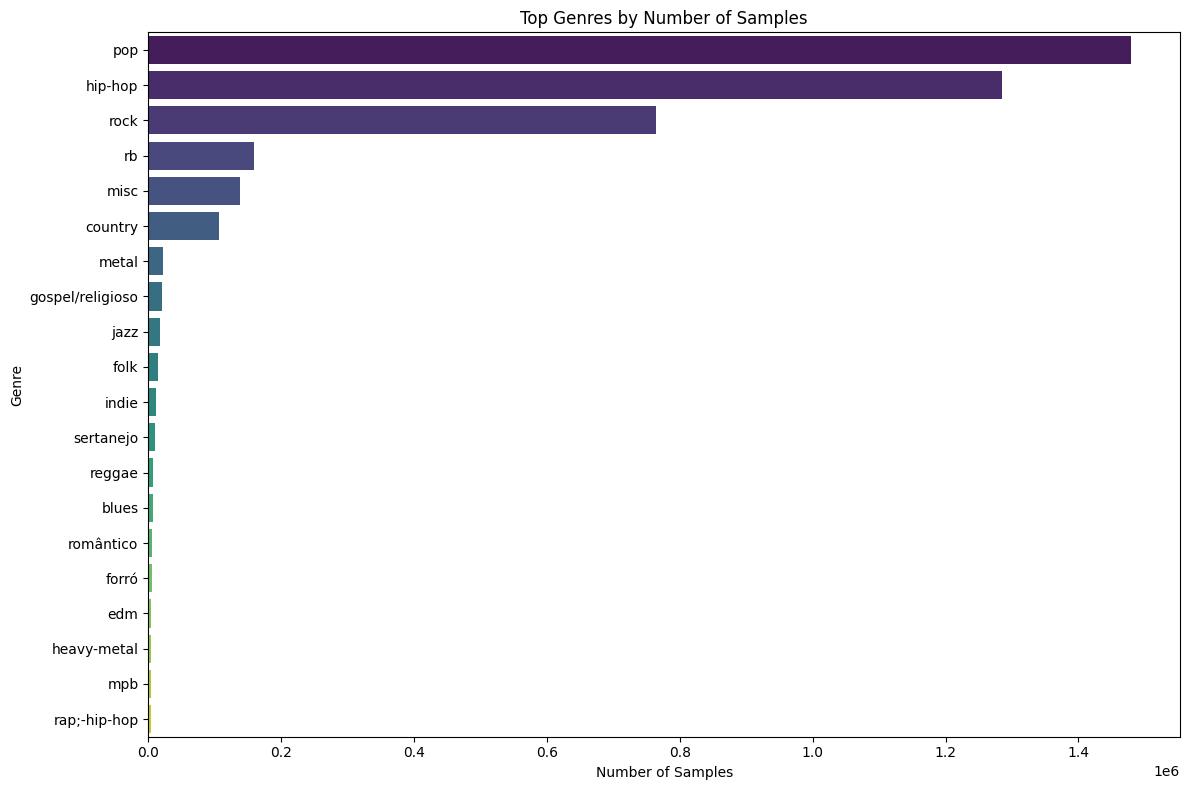

In [4]:
pdf = df.to_pandas()
genre_col, lyrics_col = df.columns[0], df.columns[1]
class_counts = pdf[genre_col].value_counts()
print("Class counts", class_counts)
top_n = 20  
top_classes = class_counts.head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_classes.values, y=top_classes.index, palette="viridis")
plt.title("Top Genres by Number of Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()
